In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=97aa2fc589fe6898ff89046bc24012f7d77d99e50fbb30653828bd300cae128a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import wget

In [3]:
file_from = 'https://datasetdumps.s3.ap-south-1.amazonaws.com/Rezang_Dataset.zip'
file_to = '/content/images.zip'
wget.download(file_from,file_to)

'/content/images.zip'

In [4]:
!unzip images.zip -d images

Archive:  images.zip
   creating: images/Dataset/
  inflating: images/__MACOSX/._Dataset  
  inflating: images/Dataset/.DS_Store  
  inflating: images/__MACOSX/Dataset/._.DS_Store  
   creating: images/Dataset/Ayrshire cattle/
  inflating: images/__MACOSX/Dataset/._Ayrshire cattle  
   creating: images/Dataset/Holstein Friesian cattle/
  inflating: images/__MACOSX/Dataset/._Holstein Friesian cattle  
   creating: images/Dataset/Jersey cattle/
  inflating: images/__MACOSX/Dataset/._Jersey cattle  
   creating: images/Dataset/Brown Swiss cattle/
  inflating: images/__MACOSX/Dataset/._Brown Swiss cattle  
   creating: images/Dataset/Red Dane cattle/
  inflating: images/__MACOSX/Dataset/._Red Dane cattle  
  inflating: images/Dataset/Ayrshire cattle/Ayrshirecattle64.jpg  
  inflating: images/__MACOSX/Dataset/Ayrshire cattle/._Ayrshirecattle64.jpg  
  inflating: images/Dataset/Ayrshire cattle/Ayrshirecattle70.jpg  
  inflating: images/__MACOSX/Dataset/Ayrshire cattle/._Ayrshirecattle70.jpg 

In [5]:
!pip install -q torchinfo

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils import data
import PIL
import numpy as np
from torch import nn
from torchinfo import summary

In [7]:
path = '/content/images/Dataset'

dataset = ImageFolder(root=path)

# Print class names and their corresponding indices
class_names = dataset.classes
class_to_idx = dataset.class_to_idx
print("Class Names:", class_names)
print("Class to Index Mapping:", class_to_idx)
print("Total number of images:", len(dataset))

Class Names: ['Ayrshire cattle', 'Brown Swiss cattle', 'Holstein Friesian cattle', 'Jersey cattle', 'Red Dane cattle']
Class to Index Mapping: {'Ayrshire cattle': 0, 'Brown Swiss cattle': 1, 'Holstein Friesian cattle': 2, 'Jersey cattle': 3, 'Red Dane cattle': 4}
Total number of images: 1208


In [8]:
import plotly.express as px

class_counts = [0] * len(class_names)
for _, label in dataset:
    class_counts[label] += 1

# Create a Plotly bar plot
fig = px.bar(x=class_names, y=class_counts, labels={'x': 'Class', 'y': 'Count'}, title='Class Distribution')
fig.update_xaxes(tickangle=-45)

fig.show()

In [9]:
gen = torch.Generator().manual_seed(42)
train_dataset, test_dataset = data.random_split(dataset, [0.8, 0.2], generator=gen)

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [11]:
data_transforms = {
    'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
            transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
train_data_aug = MyDataset(train_dataset, transform=data_transforms['train'])
train_dataset = MyDataset(train_dataset, transform=data_transforms['test'])
test_dataset = MyDataset(test_dataset, transform=data_transforms['test'])

In [13]:
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, train_data_aug])

In [14]:
train_dataloader = data.DataLoader(combined_dataset, batch_size=16, shuffle=True)

In [15]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
import matplotlib.pyplot as plt
def plot_examples(images, labels, rows=1):
    fig = plt.figure(figsize=(12, 6))
    columns = len(images) // (rows)
    for i, (img, lbl) in enumerate(zip(images, labels)):
        if i < columns*rows:
            input = img.numpy().transpose((1, 2, 0))
            input = std * input + mean
            input = np.clip(input, 0, 1)
            ax = fig.add_subplot(rows, columns, i+1)
            ax.imshow(input)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("label: {}".format(class_names[lbl]))
    plt.tight_layout()
    return fig

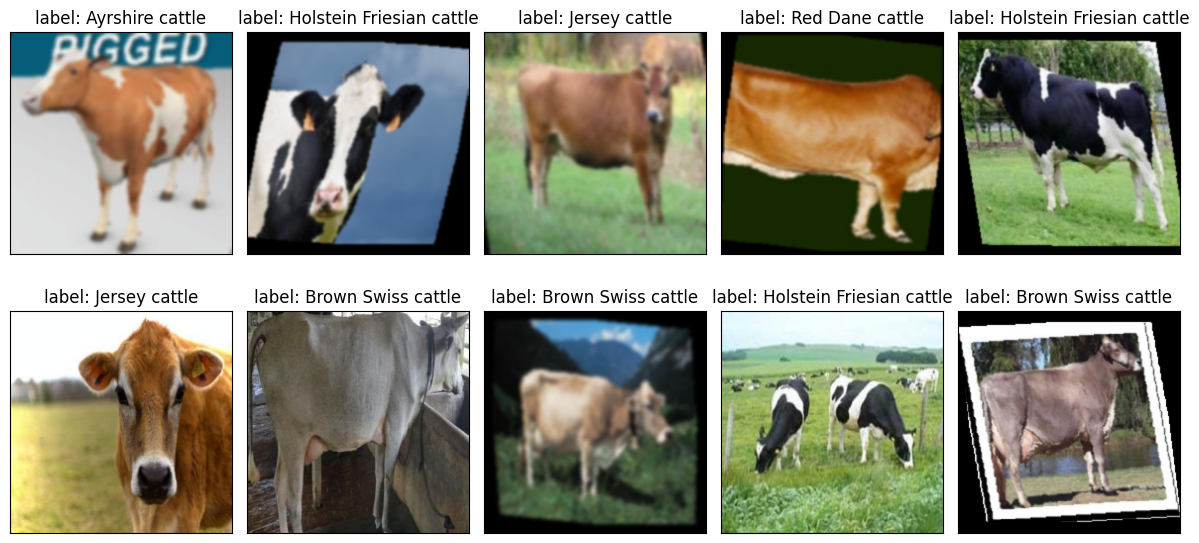

In [16]:
examples = enumerate(train_dataloader)
batch_idx, (images, labels) = next(examples)
images_=images[0:10]
labels_=labels[0:10]
plot_examples(images_, labels_, rows=2);

In [17]:
train_dataloader = data.DataLoader(combined_dataset, batch_size=16, shuffle=True)

In [18]:
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [19]:
print(len(combined_dataset))
print(len(test_dataset))

1934
241


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/data_experiment_1')

In [21]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet50_Weights.IMAGENET1K_V2

In [22]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.resnet50(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [23]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [24]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [25]:
# Set the manual seeds
torch.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, output_shape)
model = model.to(device)

In [26]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [27]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [30]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4214 | train_acc: 0.8946 | test_loss: 0.4503 | test_acc: 0.8750
Epoch: 2 | train_loss: 0.3920 | train_acc: 0.8993 | test_loss: 0.4440 | test_acc: 0.8828
Epoch: 3 | train_loss: 0.3621 | train_acc: 0.9064 | test_loss: 0.4238 | test_acc: 0.8984


KeyboardInterrupt: ignored